In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.optim as optim

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random
import copy


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as models_rf

import data_utils.data_analysis as data_analysis

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [3]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

## Loading the dataset

In [4]:
filename='datasets/galadriel_dataset_25_03_13_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number   order2   order3     order4  goodness
0           200378  34400.0 -23000.0 -5500000.0  0.878217
1           200379  34400.0 -23000.0 -5500000.0  1.025813
2           200380  34400.0 -23000.0 -5500000.0  0.853794
3           200381  34400.0 -23000.0 -5200000.0  1.003888
4           200382  34400.0 -23000.0 -5200000.0  1.022131
...            ...      ...      ...        ...       ...
15428       215808  35400.0  28000.0 -4000000.0  1.267706
15429       215809  35400.0  28000.0 -4000000.0  1.275014
15430       215810  35400.0  28000.0 -3700000.0  1.076831
15431       215811  35400.0  28000.0 -3700000.0  1.062826
15432       215812  35400.0  28000.0 -3700000.0  1.065211

[15433 rows x 5 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.4886

In [5]:
df_input.describe()

,shot number,order2,order3,order4,goodness
count,15433.000000,15433.000000,15433.000000,1.543300e+04,15433.000000
mean,208094.927363,34899.996760,2498.250502,-4.600039e+06,1.080693
std,4455.539560,302.755671,15149.603777,6.000097e+05,0.164811
min,200378.000000,34400.000000,-23000.000000,-5.500000e+06,0.680889
25%,204237.000000,34650.000000,-11000.000000,-5.200000e+06,0.958479
50%,208095.000000,34900.000000,2500.000000,-4.600000e+06,1.055294
75%,211953.000000,35150.000000,16000.000000,-4.000000e+06,1.205683
max,215812.000000,35400.000000,28000.000000,-3.700000e+06,1.731142


In [6]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

### Pulse reconstruction

In [7]:
#time in fs (it is the boundary)
#using DASK to accelerate computing
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [8]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [9]:
filename_pulse='datasets/pulse_250313.h5'

In [10]:
#read the data
#df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
#df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
#t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots with bad goodness

In [11]:
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]
df_spec_freq_reduced=df_spec_freq.iloc[good_shots_list]
df_spec_int_reduced=df_spec_int.iloc[good_shots_list]
df_spec_phase_reduced=df_spec_phase.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)
df_spec_freq_reduced.reset_index(inplace=True,drop=True)
df_spec_int_reduced.reset_index(inplace=True,drop=True)
df_spec_phase_reduced.reset_index(inplace=True,drop=True)

In [12]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,200396,34400.0,-23000.0,-3700000.0,1.224409
1,200397,34400.0,-23000.0,-3700000.0,1.309285
2,200417,34400.0,-21500.0,-3700000.0,1.258745
3,200418,34400.0,-21500.0,-3700000.0,1.246534
4,200419,34400.0,-21500.0,-3700000.0,1.259270
...,...,...,...,...,...
3990,215804,35400.0,28000.0,-4300000.0,1.224609
3991,215806,35400.0,28000.0,-4300000.0,1.231252
3992,215807,35400.0,28000.0,-4000000.0,1.276099
3993,215808,35400.0,28000.0,-4000000.0,1.267706


In [13]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

# Forward model

In [14]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


### Forwrd Linear model

In [15]:
def train_lin_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    forward_model_lin=LinearRegression().fit(X_train,y_train)

    y_predict_forward=forward_model_lin.predict(X_test)
    
    #study the erro distribution
    df_error_forward_lin=abs(y_test_reset-y_predict_forward)
    df_error_forward_lin=df_error_forward_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
    
    
    return forward_model_lin, df_error_forward_lin

In [16]:
forward_model_lin,df_error_forward_lin=train_lin_forward(X_train, X_test, y_train, y_test)

### Forward Random Forest

In [17]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

In [18]:
%%time
forward_model_rf,df_error_forward_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 5.45 s, sys: 1.24 s, total: 6.69 s
Wall time: 5.44 s


### Multi-layer Perceptron (MLP)

In [19]:
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.03415767103433609
Finished epoch 20,latest loss 0.0003841947764158249
Finished epoch 40,latest loss 0.0001897454640129581
Finished epoch 60,latest loss 0.000117123854579404
Finished epoch 80,latest loss 9.41730904742144e-05
Finished epoch 99,latest loss 8.322687790496275e-05
Total time taken to train the model: 15.92s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

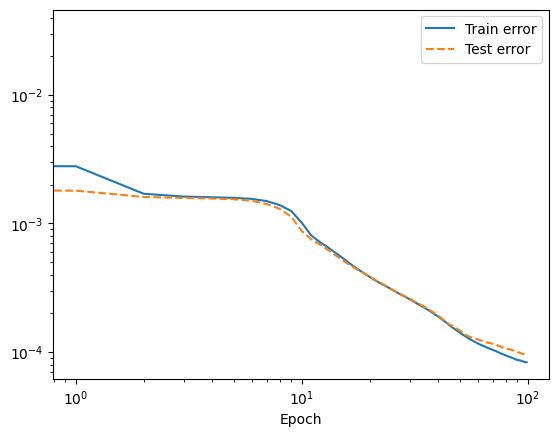

In [20]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Script dispersion method

In [21]:
def shift_pulse(p):
    #shift the pulse so the peak is at thr center of the array
    return np.roll(p,int(len(p)/2)-np.argmax(p))

In [22]:
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
df_input_reduced[(df_input_reduced['order2']==35000) &
(df_input_reduced['order3']>-1000) & (df_input_reduced['order3']<1000)]

,shot number,order2,order3,order4,goodness
2301,209519,35000.0,-500.0,-4900000.0,1.244327
2302,209520,35000.0,-500.0,-4900000.0,1.234393
2303,209521,35000.0,-500.0,-4900000.0,1.234393
2304,209522,35000.0,-500.0,-4600000.0,1.580411
2305,209523,35000.0,-500.0,-4600000.0,1.678746
2306,209524,35000.0,-500.0,-4600000.0,1.664078


In [23]:
%%time
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#for example 209523
shot_ftl=209523
ref_index=df_input_reduced[df_input_reduced['shot number']==shot_ftl].index.values[0]

time=150
time_bins=200
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
c = 299792458 ## speed of light in m/s
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
intensity=df_spec_int_reduced.loc[ref_index].to_numpy()
frequency=df_spec_freq_reduced.loc[ref_index].to_numpy()
phase=df_spec_phase_reduced.loc[ref_index].to_numpy()
p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
p_2 =copy.deepcopy(p_ref)

#get the dispersion values from this reference shot
o2_ref=df_input_reduced.loc[ref_index]['order2']
o3_ref=df_input_reduced.loc[ref_index]['order3']
o4_ref=df_input_reduced.loc[ref_index]['order4']

script_error=[]
for shot_j in range(len(df_input_reduced)):
    p_2 =copy.deepcopy(p_ref) #fresh copy every time
    #desired pulse
    #shot_j=50
    o2_final=df_input_reduced.loc[shot_j]['order2']
    o3_final=df_input_reduced.loc[shot_j]['order3']
    o4_final=df_input_reduced.loc[shot_j]['order4']

    #add dispersion
    p_2.dispersion(2,o2_final-o2_ref)
    p_2.dispersion(3,o3_final-o3_ref)
    p_2.dispersion(4,o4_final-o4_ref)

    #shift the pulses so the peak at the center
    p2_s=shift_pulse(p_2.intensity)
    pmeas_s=shift_pulse(df_pulse_200_reduced.iloc[shot_j]) #measured shot 

    #mae error
    error=abs(p2_s-pmeas_s)
    error=error.sum()/len(p2_s)
    script_error.append(error)
script_error=np.array(script_error)

CPU times: user 2min 31s, sys: 92.1 ms, total: 2min 31s
Wall time: 2min 31s


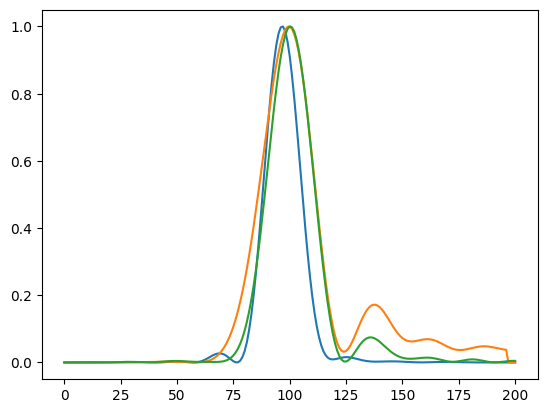

In [24]:
plt.plot(p_ref.intensity)
plt.plot(p2_s)
plt.plot(pmeas_s)

### Predictions

Text(0, 0.5, 'Intensity')

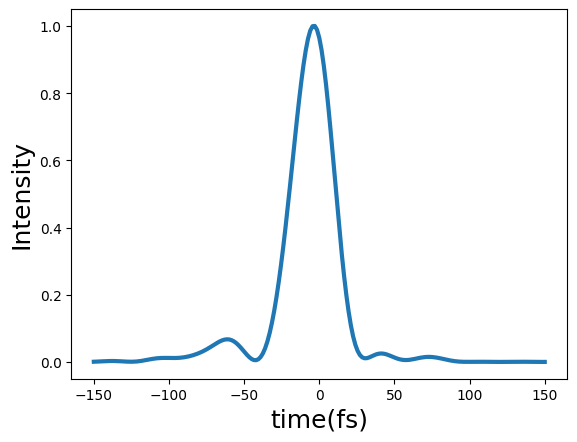

In [25]:
shot_index=35
plt.plot(df_time_200,y_test.iloc[shot_index],linewidth=3)
plt.xlabel('time(fs)',fontsize=18)
plt.ylabel('Intensity',fontsize=18)

In [26]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_lin,forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_lin=forward_model_lin.predict(X_values)
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_lin[0],label='Prediction (Linear)',linewidth=3,linestyle='-')
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')

    mae_lin=abs(y_test.iloc[shot_index]-y_predict_forward_lin[0])
    mae_lin=mae_lin.sum()/len(y_test.iloc[shot_index])
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.text(-120,0.7,r'$MAE_{{Lin}}={:.1f}$%'.format(100*mae_lin))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

In [27]:
def plot_example_wth_script(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_lin,forward_model_rf,forward_model_mlp,
                            shot_ftl,df_spec_int,df_spec_freq,df_spec_phase):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_lin=forward_model_lin.predict(X_values)
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)

    #built the reference pulse with the script
    #shot_ftl=168758
    ref_index=df_input[df_input['shot number']==shot_ftl].index.values[0]

    #get the dispersion values from this reference shot
    o2_ref=df_input.loc[ref_index]['order2']
    o3_ref=df_input.loc[ref_index]['order3']
    o4_ref=df_input.loc[ref_index]['order4']

    time=int(df_time_val.max())#150
    time_bins=len(df_time_val)-1#200
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    intensity=df_spec_int.loc[ref_index].to_numpy()
    frequency=df_spec_freq.loc[ref_index].to_numpy()
    phase=df_spec_phase.loc[ref_index].to_numpy()
    p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)

    #add dispersion
    p_ref.dispersion(2,order2-o2_ref)
    p_ref.dispersion(3,order3-o3_ref)
    p_ref.dispersion(4,order4-o4_ref)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,p_ref.intensity,label='Script',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_lin[0],label='Prediction (Linear)',linewidth=3,linestyle='-')
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')

    mae_lin=abs(y_test.iloc[shot_index]-y_predict_forward_lin[0])
    mae_lin=mae_lin.sum()/len(y_test.iloc[shot_index])
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.text(-120,0.7,r'$MAE_{{Lin}}={:.1f}$%'.format(100*mae_lin))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

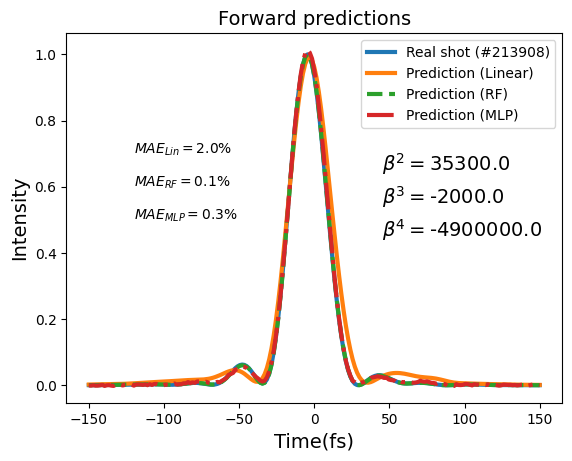

In [28]:
shot_index=75
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

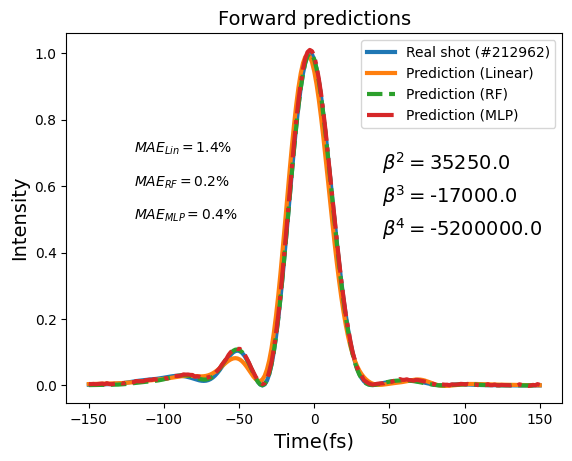

In [29]:
shot_index=512
plot_example(shot_index,X_test,y_test,df_input_reduced,df_time_200,
             forward_model_lin,forward_model_rf,forward_model_mlp)

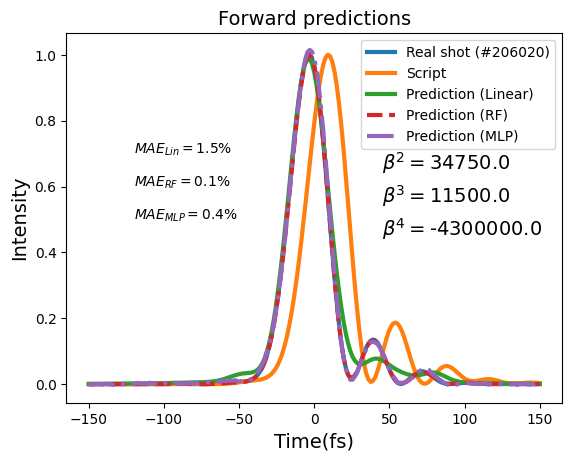

In [30]:
shot_index=510
plot_example_wth_script(shot_index,X_test,y_test,df_input_reduced,df_time_200,
                 forward_model_lin,forward_model_rf,forward_model_mlp,
                            209523,#reference shot
                        df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)

Text(0.5, 1.0, 'Model Accuracy (Forward)')

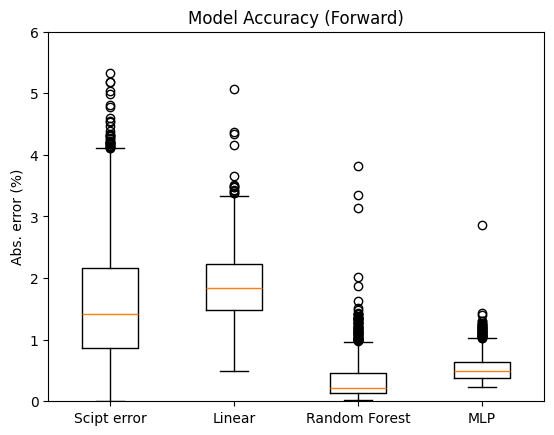

In [31]:
error_dist=[100*script_error,
            100*df_error_forward_lin,
            100*df_error_forward_rf,
           100*error_fwd_model_mlp]
labels=['Scipt error','Linear','Random Forest','MLP']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')

      Analytic    Linear        RF       MLP
0     1.788710  1.744585  0.357402  0.529475
1     2.060261  2.458299  0.097702  0.495900
2     1.586375  1.993469  1.632005  1.155742
3     1.701122  1.458141  0.107058  0.294767
4     1.985737  2.697690  0.029677  0.315339
...        ...       ...       ...       ...
3990  3.705656       NaN       NaN       NaN
3991  3.181421       NaN       NaN       NaN
3992  3.806930       NaN       NaN       NaN
3993  3.764541       NaN       NaN       NaN
3994  3.797324       NaN       NaN       NaN

[3995 rows x 4 columns]


(0.0, 5.0)

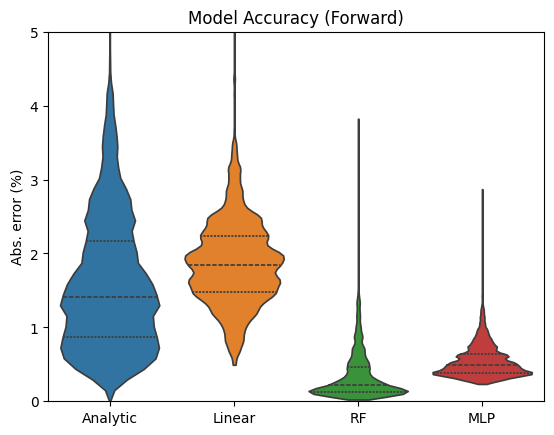

In [32]:
df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=False,orient='v')
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.ylim(0,5)

      Analytic    Linear        RF       MLP
0     1.788710  1.744585  0.357402  0.529475
1     2.060261  2.458299  0.097702  0.495900
2     1.586375  1.993469  1.632005  1.155742
3     1.701122  1.458141  0.107058  0.294767
4     1.985737  2.697690  0.029677  0.315339
...        ...       ...       ...       ...
3990  3.705656       NaN       NaN       NaN
3991  3.181421       NaN       NaN       NaN
3992  3.806930       NaN       NaN       NaN
3993  3.764541       NaN       NaN       NaN
3994  3.797324       NaN       NaN       NaN

[3995 rows x 4 columns]


(0.0, 5.0)

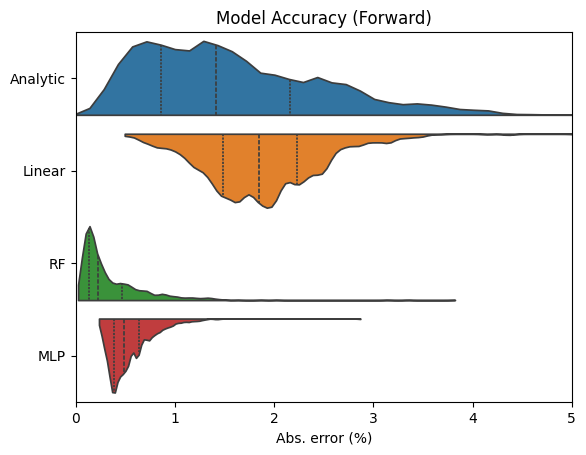

In [33]:
df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)

## Impact of shot averaging on models

In [34]:
#Average shots with same input param
def shot_average(df_input,df_time,df_spec_freq,df_spec_int,df_spec_phase):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    goodness_mean=[]
    wizz_mean=[]
    freq_mean=[]
    int_mean=[]
    phase_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            freq_list=df_spec_freq.iloc[index].to_numpy()
            int_list=df_spec_int.iloc[index].to_numpy()
            phase_list=df_spec_phase.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                freq_list=np.vstack([freq_list,df_spec_freq.iloc[index].to_numpy()])
                int_list=np.vstack([int_list,df_spec_int.iloc[index].to_numpy()])
                phase_list=np.vstack([phase_list,df_spec_phase.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                freq_mean.append(np.mean(freq_list,axis=0))
                int_mean.append(np.mean(int_list,axis=0))
                phase_mean.append(np.mean(phase_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                freq_list=df_spec_freq.iloc[index].to_numpy()
                int_list=df_spec_int.iloc[index].to_numpy()
                phase_list=df_spec_phase.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()    
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    df_input_avg['goodness mean']=goodness_mean
    df_time_avg=pd.DataFrame(wizz_mean)
    df_spec_freq_avg=pd.DataFrame(freq_mean)
    df_spec_int_avg=pd.DataFrame(int_mean)
    df_spec_phase_avg=pd.DataFrame(phase_mean)
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg,df_spec_freq_avg,df_spec_int_avg,df_spec_phase_avg

In [35]:
#AVG pulses
df_input_avg,df_pulse_200_avg,df_spec_freq_avg,df_spec_int_avg,df_spec_phase_avg=shot_average(df_input,df_pulse_200,df_spec_freq,df_spec_int,df_spec_phase)

In [36]:
print(len(df_input_avg))
print(len(df_pulse_200_avg))

5144
5144


In [37]:
#Drop the avg shots with low goodness
df_input_avg=df_input_avg[df_input_avg['goodness mean']>goodness_val]

good_shots_list=df_input_avg.index.values
#print(good_shots_list)
df_pulse_200_avg=df_pulse_200_avg.iloc[good_shots_list]
df_spec_freq_avg=df_spec_freq_avg.iloc[good_shots_list]
df_spec_int_avf=df_spec_int_avg.iloc[good_shots_list]
df_spec_phase_avg=df_spec_phase_avg.iloc[good_shots_list]

#reset the index
df_input_avg.reset_index(inplace=True,drop=True)
df_pulse_200_avg.reset_index(inplace=True,drop=True)
df_spec_freq_avg.reset_index(inplace=True,drop=True)
df_spec_int_avg.reset_index(inplace=True,drop=True)
df_spec_phase_avg.reset_index(inplace=True,drop=True)

In [38]:
print(df_input_avg)
print(df_pulse_200_avg)

       order2   order3     order4  goodness mean
0     34400.0 -23000.0 -3700000.0       1.238517
1     34400.0 -21500.0 -3700000.0       1.254850
2     34400.0 -20000.0 -3700000.0       1.271919
3     34400.0 -18500.0 -3700000.0       1.269849
4     34400.0 -17000.0 -4000000.0       1.204996
...       ...      ...        ...            ...
1271  35400.0  23500.0 -4000000.0       1.234282
1272  35400.0  25000.0 -4300000.0       1.249531
1273  35400.0  25000.0 -4000000.0       1.239897
1274  35400.0  26500.0 -4000000.0       1.265462
1275  35400.0  28000.0 -4000000.0       1.272940

[1276 rows x 4 columns]
           0         1         2         3         4         5         6    \
0     0.000853  0.000841  0.000739  0.000562  0.000352  0.000160  0.000045   
1     0.000680  0.000756  0.000750  0.000659  0.000501  0.000313  0.000148   
2     0.000532  0.000497  0.000412  0.000292  0.000163  0.000056  0.000006   
3     0.000514  0.000485  0.000406  0.000293  0.000169  0.000065  0.000011 

In [39]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train_avg, X_test_avg, y_train_avg, y_test_avg=models_tools.split_dataset_roundtrip(df_input_avg,df_pulse_200_avg,rand_split=False)

**Train the models**

In [40]:
forward_model_lin_avg,df_error_forward_lin_avg=train_lin_forward(X_train_avg, X_test_avg, y_train_avg, y_test_avg)

In [41]:
forward_model_rf_avg,df_error_forward_rf_avg=train_rf_forward(X_train_avg, X_test_avg, y_train_avg, y_test_avg)

In [42]:
forward_model_mlp_avg=models_fcnn.FWmodelNN(X_train_avg,y_train_avg,X_test_avg,y_test_avg,device)
forward_model_mlp_avg.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_avg=forward_model_mlp_avg.predict(X_test_avg)
error_fwd_model_mlp_avg=forward_model_mlp_avg.error_calc_mae()

Finished epoch 0,latest loss 0.025146760046482086
Finished epoch 20,latest loss 0.00016194592171814293
Finished epoch 40,latest loss 9.697404311737046e-05
Finished epoch 60,latest loss 7.695560634601861e-05
Finished epoch 80,latest loss 6.390778435161337e-05
Finished epoch 99,latest loss 5.507494279299863e-05
Total time taken to train the model: 15.38s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

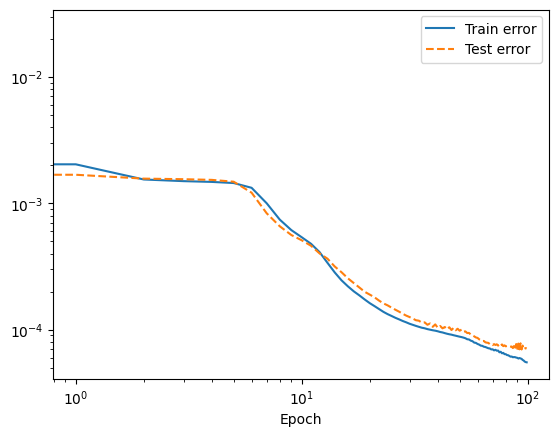

In [43]:
plt.plot(forward_model_mlp_avg.train_error,label='Train error')
plt.plot(forward_model_mlp_avg.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Script error in avg shots

In [44]:
#first we need to find the avg shots with the values close to FTL (o2=35000, o3=0, and o4=-4.5e6)
df_input_avg[(df_input_avg['order2']==35000) & (df_input_avg['order3']>-1000) &
 (df_input_avg['order3']<1000)]

,order2,order3,order4,goodness mean
735,35000.0,-500.0,-4900000.0,1.237705
736,35000.0,-500.0,-4600000.0,1.641078


In [45]:
#%%time
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#for example 168758
#shot_ftl=168758
#ref_index=df_input_reduced[df_input_reduced['shot number']==shot_ftl].index.values[0]
ref_index=736


time=int(df_time_200.max())#150
time_bins=len(df_time_200)-1#200
print(time)
print(time_bins)
t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
c = 299792458 ## speed of light in m/s
center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
intensity=df_spec_int_avg.loc[ref_index].to_numpy()
frequency=df_spec_freq_avg.loc[ref_index].to_numpy()
phase=df_spec_phase_avg.loc[ref_index].to_numpy()
p_ref = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
p_2 =copy.deepcopy(p_ref)

#get the dispersion values from this reference shot
o2_ref=df_input_avg.loc[ref_index]['order2']
o3_ref=df_input_avg.loc[ref_index]['order3']
o4_ref=df_input_avg.loc[ref_index]['order4']

script_error_avg=[]
for shot_j in range(len(df_input_avg)):
    p_2 =copy.deepcopy(p_ref) #fresh copy every time
    #desired pulse
    #shot_j=50
    o2_final=df_input_avg.loc[shot_j]['order2']
    o3_final=df_input_avg.loc[shot_j]['order3']
    o4_final=df_input_avg.loc[shot_j]['order4']

    #add dispersion
    p_2.dispersion(2,o2_final-o2_ref)
    p_2.dispersion(3,o3_final-o3_ref)
    p_2.dispersion(4,o4_final-o4_ref)

    #shift the pulses so the peak at the center
    p2_s=shift_pulse(p_2.intensity)
    pmeas_s=shift_pulse(df_pulse_200_avg.iloc[shot_j]) #measured shot 

    #mae error
    error=abs(p2_s-pmeas_s)
    error=error.sum()/len(p2_s)
    script_error_avg.append(error)
script_error_avg=np.array(script_error_avg)

150
200


Text(0.5, 1.0, 'Impact average shots (FWD models)')

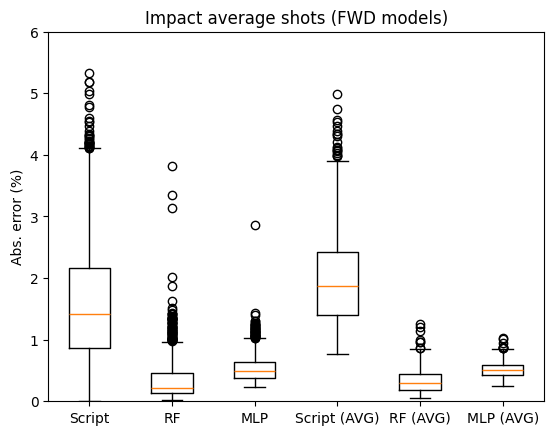

In [46]:
error_dist=[100*script_error,
            100*df_error_forward_rf,
           100*error_fwd_model_mlp,
            100*script_error_avg,
           100*df_error_forward_rf_avg,
           100*error_fwd_model_mlp_avg]
labels=['Script','RF','MLP','Script (AVG)','RF (AVG)','MLP (AVG)']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,6)
plt.ylabel('Abs. error (%)')
plt.title('Impact average shots (FWD models)')

        Error Dataset   Model
0    1.788710     All  Script
1    2.060261     All  Script
2    1.586375     All  Script
3    1.701122     All  Script
4    1.985737     All  Script
..        ...     ...     ...
378  0.379948     Avg     MLP
379  0.704509     Avg     MLP
380  0.749545     Avg     MLP
381  0.511325     Avg     MLP
382  0.294143     Avg     MLP

[8435 rows x 3 columns]


(0.0, 4.0)

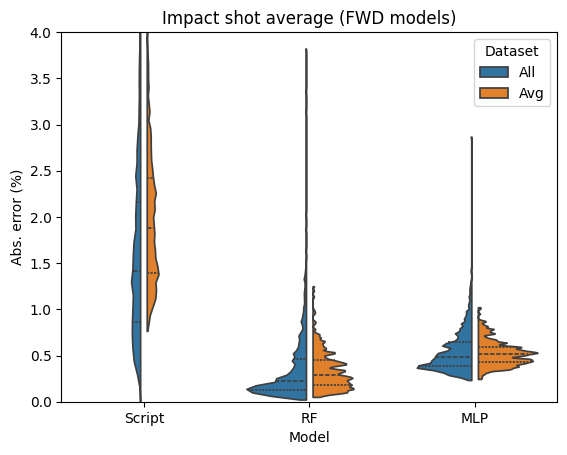

In [47]:
df_plot=pd.DataFrame({'Error':100*pd.Series(script_error),'Dataset':'All','Model':'Script'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'All','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'All','Model':'MLP'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*pd.Series(script_error_avg),'Dataset':'Avg','Model':'Script'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_avg,'Dataset':'Avg','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_avg,'Dataset':'Avg','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Model',y='Error',hue='Dataset',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
plt.ylabel('Abs. error (%)')
plt.xlabel('Model')
plt.title('Impact shot average (FWD models)')
plt.ylim(0,4)

        Error Dataset     Model
0    1.788710     All  Analytic
1    2.060261     All  Analytic
2    1.586375     All  Analytic
3    1.701122     All  Analytic
4    1.985737     All  Analytic
..        ...     ...       ...
378  0.379948     Avg       MLP
379  0.704509     Avg       MLP
380  0.749545     Avg       MLP
381  0.511325     Avg       MLP
382  0.294143     Avg       MLP

[8435 rows x 3 columns]


(0.0, 4.0)

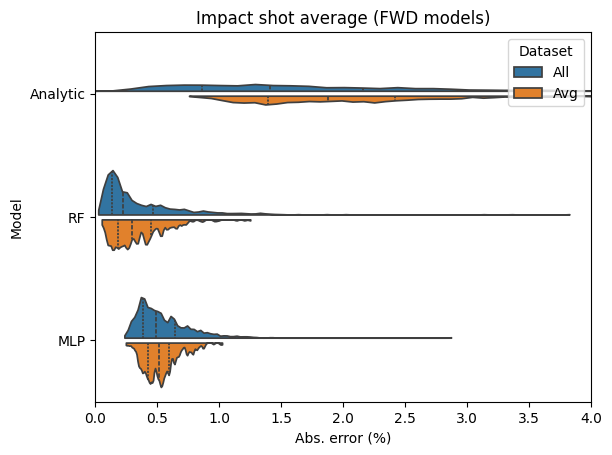

In [48]:
df_plot=pd.DataFrame({'Error':100*pd.Series(script_error),'Dataset':'All','Model':'Analytic'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'All','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'All','Model':'MLP'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*pd.Series(script_error_avg),'Dataset':'Avg','Model':'Analytic'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_avg,'Dataset':'Avg','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_avg,'Dataset':'Avg','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Error',y='Model',hue='Dataset',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
#plt.ylabel('Model')
plt.title('Impact shot average (FWD models)')
plt.xlim(0,4)

### Impact of dataset size

In [49]:
def drop_shots(drop_factor,df_input,df_time):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [50]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 2198
The datasize is no: 1598
The datasize is no: 760


In [51]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=models_tools.split_dataset_roundtrip(df_input_subset_1500,df_time_subset_1500,rand_split=False)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=models_tools.split_dataset_roundtrip(df_input_subset_1k,df_time_subset_1k,rand_split=False)
X_train_500, X_test_500, y_train_500, y_test_500=models_tools.split_dataset_roundtrip(df_input_subset_500,df_time_subset_500,rand_split=False)

In [52]:
#Training the Random Forest forward models
forward_model_rf_1500,df_error_forward_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k,df_error_forward_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500,df_error_forward_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

In [53]:
#Training the MLP forward models
forward_model_mlp_1500=models_fcnn.FWmodelNN(X_train_1500,y_train_1500,X_test_1500,y_test_1500,device)
forward_model_mlp_1500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1500=forward_model_mlp_1500.predict(X_test_1500)
error_fwd_model_mlp_1500=forward_model_mlp_1500.error_calc_mae()
print()

forward_model_mlp_1k=models_fcnn.FWmodelNN(X_train_1k,y_train_1k,X_test_1k,y_test_1k,device)
forward_model_mlp_1k.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_1k=forward_model_mlp_1k.predict(X_test_1k)
error_fwd_model_mlp_1k=forward_model_mlp_1k.error_calc_mae()

print()
forward_model_mlp_500=models_fcnn.FWmodelNN(X_train_500,y_train_500,X_test_500,y_test_500,device)
forward_model_mlp_500.train(100,#epochs 
                 32,#batch size
                 20, #print freq
                 0.001) #learning rate
y_predict_nn_fwd_500=forward_model_mlp_500.predict(X_test_500)
error_fwd_model_mlp_500=forward_model_mlp_500.error_calc_mae()

Finished epoch 0,latest loss 0.01703648455440998
Finished epoch 20,latest loss 0.00034881787723861635
Finished epoch 40,latest loss 0.0001366128126392141
Finished epoch 60,latest loss 0.00011044927668990567
Finished epoch 80,latest loss 9.796414815355092e-05
Finished epoch 99,latest loss 8.863094262778759e-05
Total time taken to train the model: 28.71s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.020631497725844383
Finished epoch 20,latest loss 0.00020694095292128623
Finished epoch 40,latest loss 0.00012145837536081672
Finished epoch 60,latest loss 0.00010053388541564345
Finished epoch 80,latest loss 8.875739149516448e-05
Finished epoch 99,latest loss 8.276158041553572e-05
Total time taken to train the model: 14.37s
Calculating the Mean Absolute Error

Finished epoch 0,latest loss 0.04275868460536003
Finished epoch 20,latest loss 0.00041169457836076617
Finished epoch 40,latest loss 0.00020133238285779953
Finished epoch 60,latest loss 0.00014852343883831054
Finish

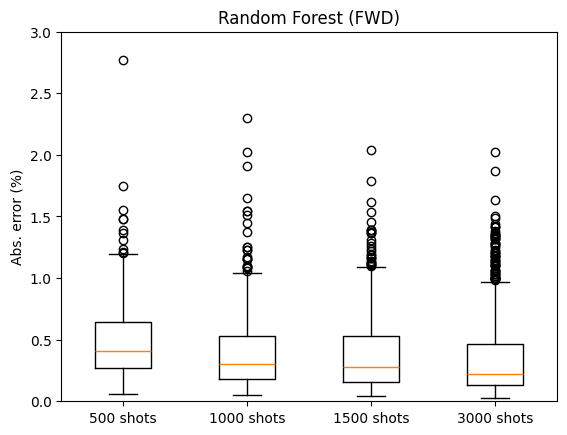

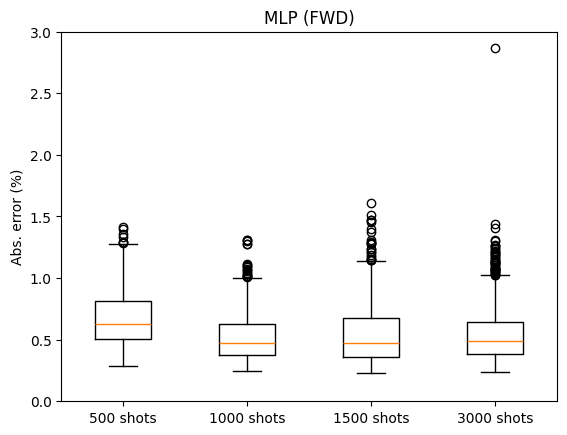

In [54]:
error_dist=[100*df_error_forward_rf_500,
            100*df_error_forward_rf_1k,
            100*df_error_forward_rf_1500,
            100*df_error_forward_rf]
labels=['500 shots','1000 shots','1500 shots','3000 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,3)
plt.ylabel('Abs. error (%)')
plt.title('Random Forest (FWD)')
plt.show()

error_dist=[100*error_fwd_model_mlp_500,
            100*error_fwd_model_mlp_1k,
            100*error_fwd_model_mlp_1500,
            100*error_fwd_model_mlp]
labels=['500 shots','1000 shots','1500 shots','3000 shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,3)
plt.ylabel('Abs. error (%)')
plt.title('MLP (FWD)')
plt.show()

         Error Dataset Model
0     0.846471     500    RF
1     0.343094     500    RF
2     0.529794     500    RF
3     0.085404     500    RF
4     0.378159     500    RF
...        ...     ...   ...
1194  0.456000    3000   MLP
1195  0.398737    3000   MLP
1196  0.684675    3000   MLP
1197  0.595155    3000   MLP
1198  0.251688    3000   MLP

[5134 rows x 3 columns]


(0.0, 3.0)

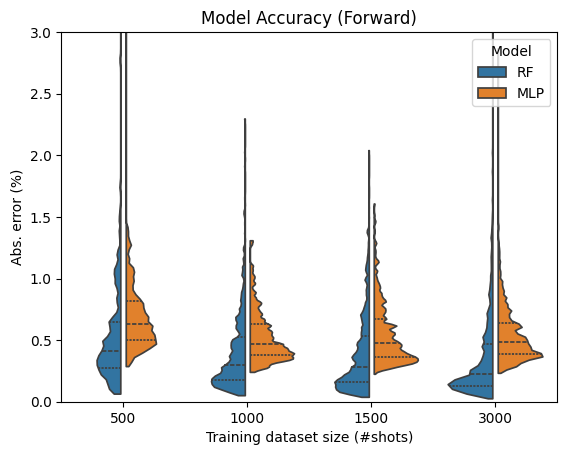

In [55]:
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
#sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.ylabel('Abs. error (%)')
plt.xlabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Forward)')
plt.ylim(0,3)
#plt.xlim(0,3)

         Error Dataset Model
0     0.846471     500    RF
1     0.343094     500    RF
2     0.529794     500    RF
3     0.085404     500    RF
4     0.378159     500    RF
...        ...     ...   ...
1194  0.456000    3000   MLP
1195  0.398737    3000   MLP
1196  0.684675    3000   MLP
1197  0.595155    3000   MLP
1198  0.251688    3000   MLP

[5134 rows x 3 columns]


(0.0, 3.0)

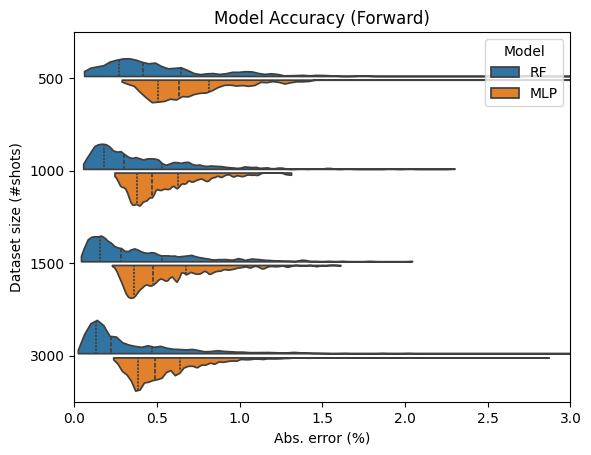

In [56]:
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

#sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Dataset size (#shots)')
plt.title('Model Accuracy (Forward)')
#plt.ylim(0,3)
plt.xlim(0,3)

      Analytic    Linear        RF       MLP
0     1.788710  1.744585  0.357402  0.529475
1     2.060261  2.458299  0.097702  0.495900
2     1.586375  1.993469  1.632005  1.155742
3     1.701122  1.458141  0.107058  0.294767
4     1.985737  2.697690  0.029677  0.315339
...        ...       ...       ...       ...
3990  3.705656       NaN       NaN       NaN
3991  3.181421       NaN       NaN       NaN
3992  3.806930       NaN       NaN       NaN
3993  3.764541       NaN       NaN       NaN
3994  3.797324       NaN       NaN       NaN

[3995 rows x 4 columns]
         Error Dataset Model
0     0.846471     500    RF
1     0.343094     500    RF
2     0.529794     500    RF
3     0.085404     500    RF
4     0.378159     500    RF
...        ...     ...   ...
1194  0.456000    3000   MLP
1195  0.398737    3000   MLP
1196  0.684675    3000   MLP
1197  0.595155    3000   MLP
1198  0.251688    3000   MLP

[5134 rows x 3 columns]


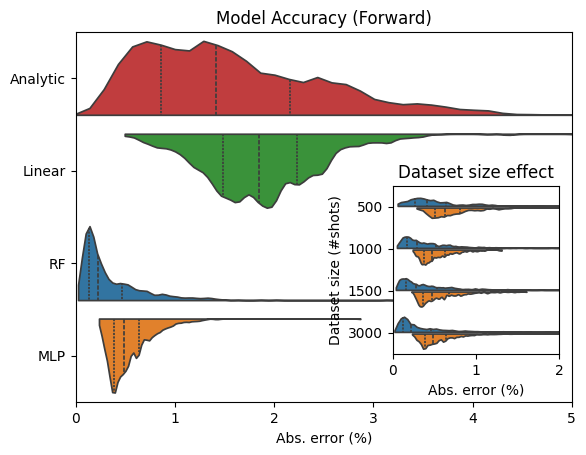

In [57]:
fig = plt.figure() #fig needed to add_axes later

df_plot=pd.DataFrame({'Analytic':pd.Series(100*script_error),'Linear':100*df_error_forward_lin,
                      'RF':100*df_error_forward_rf,
                      'MLP':100*error_fwd_model_mlp})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Forward)')
plt.xlim(0,5)


#inset plot
df_plot=pd.DataFrame({'Error':100*df_error_forward_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*df_error_forward_rf,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_500,'Dataset':'500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1k,'Dataset':'1000','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp_1500,'Dataset':'1500','Model':'MLP'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*error_fwd_model_mlp,'Dataset':'3000','Model':'MLP'})))

print(df_plot)

ax = fig.add_axes([0.62, 0.21, 0.26, 0.35], facecolor='white') #[left, bottom, width, height]
#sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
#               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='v')
sns.violinplot(data=df_plot,x='Error',y='Dataset',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.2,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Dataset size (#shots)')
plt.title('Dataset size effect')
#plt.ylim(0,3)
plt.xlim(0,2)
ax.get_legend().remove()

## Different days